### Time series forecasting using Facebook Prophet [GitHub link](https://github.com/facebook/prophet) [Documentation page](https://facebook.github.io/prophet/docs/quick_start.html)

In [1]:
%load_ext watermark
%load_ext lab_black

# make autocomplet working
%config Completer.use_jedi = False

#### Install libraries and import dependencies

In [2]:
# Use conda env for this notebook so there won't be errors while installing pystan and fbprophet
#!pip install pystan
#! conda install -c conda-forge fbprophet

In [3]:
import pandas as pd
import fbprophet
import matplotlib.pyplot as plt

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

#### Importing dataset and exploring it

In [4]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/master/monthly-milk-production-pounds.csv"
)
df

,Month,Monthly milk production (pounds per cow)
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727
...,...,...
163,1975-08,858
164,1975-09,817
165,1975-10,827
166,1975-11,797


In [5]:
df.tail()

,Month,Monthly milk production (pounds per cow)
163,1975-08,858
164,1975-09,817
165,1975-10,827
166,1975-11,797
167,1975-12,843


In [6]:
# check if there is any null values
df.isnull().sum()

Month                                       0
Monthly milk production (pounds per cow)    0
dtype: int64

In [7]:
# rename the column name (prophet needs to be this kind)
df.columns = ["ds", "y"]
df.head()

,ds,y
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      168 non-null    object
 1   y       168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


In [9]:
# lets change the ds to datetime format
df["ds"] = pd.to_datetime(df["ds"])
df.head()

,ds,y
0,1962-01-01,589
1,1962-02-01,561
2,1962-03-01,640
3,1962-04-01,656
4,1962-05-01,727


<AxesSubplot:>

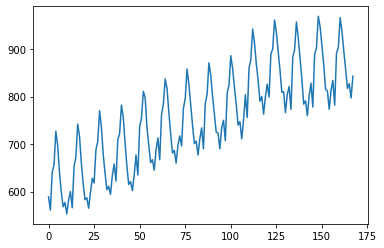

In [10]:
# lets plot the data
df["y"].plot()

**The data seems to have seasonality but the `fbprophet` will handle this by itself. In `Arima model`, we need to change the data into stationary but here we don't have to.**

#### Implementation of fbprohet starts from here

In [11]:
from fbprophet import Prophet

In [12]:
# initialize the model
model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
model.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

In [14]:
model.component_modes

{'additive': ['yearly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [15]:
# In order to do the prediction, lets first create future dates of 365 days
future_dates = model.make_future_dataframe(periods=365)
future_dates

,ds
0,1962-01-01
1,1962-02-01
2,1962-03-01
3,1962-04-01
4,1962-05-01
...,...
528,1976-11-26
529,1976-11-27
530,1976-11-28
531,1976-11-29


In [16]:
# prediction
prediction = model.predict(future_dates)
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1962-01-01,606.941323,576.385270,596.573116,606.941323,606.941323,-20.151798,-20.151798,-20.151798,-20.151798,-20.151798,-20.151798,0.0,0.0,0.0,586.789525
1,1962-02-01,608.656256,535.201397,555.980091,608.656256,608.656256,-62.588619,-62.588619,-62.588619,-62.588619,-62.588619,-62.588619,0.0,0.0,0.0,546.067637
2,1962-03-01,610.205228,631.168813,651.460304,610.205228,610.205228,31.365739,31.365739,31.365739,31.365739,31.365739,31.365739,0.0,0.0,0.0,641.570967
3,1962-04-01,611.920161,648.735209,668.157225,611.920161,611.920161,46.703773,46.703773,46.703773,46.703773,46.703773,46.703773,0.0,0.0,0.0,658.623935
4,1962-05-01,613.579774,711.646099,731.586932,613.579774,613.579774,108.040207,108.040207,108.040207,108.040207,108.040207,108.040207,0.0,0.0,0.0,721.619981


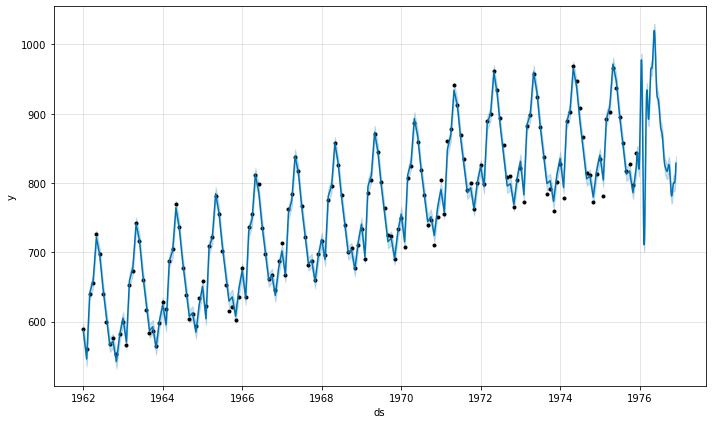

In [17]:
## lets plot the prediction with the inbuilt feature `model.plot()`
# put ; to avoid two plots being displayed.It was same in Arima model too, don't know why they keep doing this.
model.plot(prediction)

**The blue line in the graph represents the predicted values while the black dots represents the data in our dataset. The last plot without black dots is the future prediction. The light blue shown is the trends. It actually predicting almost perfect.**

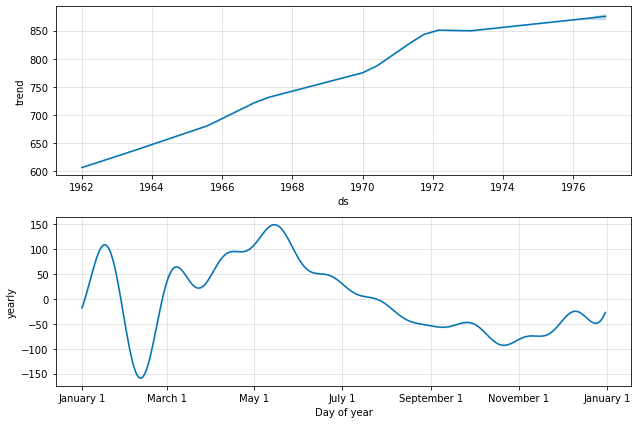

In [18]:
# lets visualize each components (trends, yearly)
model.plot_components(prediction)

#### Cross validation and performance metrics from fbprophet library itself 
- this cross-validation is different from the sklearn one.
- In order to perform this operation we select cut of points in the history of the data and fit the model with data upto that cut off point. Afterwards we compare the actual values to the predicted values. The cross_validation method allows us to do this in Prophet.

In [22]:
from fbprophet.diagnostics import cross_validation

In [35]:
# cross_validation??

In [23]:
df_cv = cross_validation(
    model, horizon="365 days", period="180 days", initial="1095 days"
)

INFO:fbprophet:Making 21 forecasts with cutoffs between 1965-01-22 00:00:00 and 1974-12-01 00:00:00


  0%|          | 0/21 [00:00<?, ?it/s]

In [34]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1965-02-01,630.734519,628.854492,632.250921,622,1965-01-22
1,1965-03-01,715.209269,708.938681,721.306243,709,1965-01-22
2,1965-04-01,738.046179,725.484658,750.735633,722,1965-01-22
3,1965-05-01,809.508773,788.895280,829.681929,782,1965-01-22
4,1965-06-01,778.278652,746.720735,807.593899,756,1965-01-22
...,...,...,...,...,...,...
247,1975-08-01,849.442177,839.836677,859.699854,858,1974-12-01
248,1975-09-01,806.953913,796.446966,816.617747,817,1974-12-01
249,1975-10-01,810.381389,800.210162,820.995355,827,1974-12-01
250,1975-11-01,778.431546,767.458266,789.352593,797,1974-12-01


In [25]:
df.head()

,ds,y
0,1962-01-01,589
1,1962-02-01,561
2,1962-03-01,640
3,1962-04-01,656
4,1962-05-01,727


In [26]:
# performance metrics
from fbprophet.diagnostics import performance_metrics

df_pm = performance_metrics(df_cv)
df_pm

,horizon,mse,rmse,mae,mape,mdape,coverage
0,38 days,255.110328,15.972174,12.522709,0.016138,0.014043,0.36
1,41 days,253.085086,15.908648,12.440669,0.016069,0.014043,0.36
2,42 days,267.466632,16.354407,12.890051,0.016696,0.014071,0.36
3,43 days,267.960409,16.369496,13.005926,0.016878,0.014071,0.36
4,46 days,252.637615,15.894578,12.615442,0.016331,0.014071,0.36
...,...,...,...,...,...,...,...
180,357 days,884.015365,29.732396,22.644878,0.028549,0.023298,0.40
181,360 days,690.792073,26.282924,19.536284,0.024325,0.017204,0.44
182,361 days,678.229374,26.042837,19.143664,0.023926,0.013927,0.44
183,362 days,661.483112,25.719314,18.431256,0.023110,0.013880,0.48


In [29]:
##fbprophet.plot.plot_cross_validation_metric??

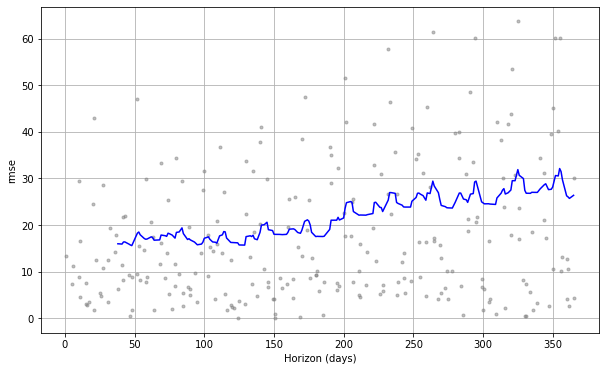

In [32]:
# lets plot it
# Valid values of metric are 'mse', 'rmse', 'mae', 'mape', and 'coverage'.
from fbprophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric="rmse")